## Tutorial 14-02 - Analyzing Change Between Rasters

In our previous tutorial, we looked at the change in development in a section of Mountain View, CA.  We could see visually that there was siginificant change over the course of ten years.  In this tutorial, we'll attempt to quantify that change.

## Gather Input Data

In the previous exercise, we gathered data as jpegs.  Let's do the same here but with tiff files. While the jpegs were nice for visual inspection, tiff files can be georeferenced and used as inputs for further analysis.

#### 1.  Repeat the previous tutorial logic for setup.

The following cells are selected from the previous tutorial.  Note that we're not displaying anything on a map now as we've already done our data exploration.  Gather all the code from the previous Notebook where you accessed the NAIP imagery and set up the bounding box, list of years and timestamps, and the pixel size to export.

In [1]:
# imports
import arcgis
import datetime
import pandas as pd

In [2]:
# sign into ArcGIS Online
gis = arcgis.GIS("home")

<Item title:"USA NAIP Imagery: Natural Color" type:Imagery Layer owner:esri>
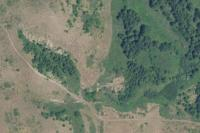

In [3]:
# gather the NAIP item
naip_item = gis.content.get("3f8d2d3828f24c00ae279db4af26d566")
naip_item

In [4]:
# gather the NAIP layer
lyr_naip = naip_item.layers[0]

In [5]:
# define extent by tuple
in_extent = (-13530675.228816083, 4545237.670432766, -13528866.137925146, 4547533.238415405) 

# unpack the extent tuple into individual variables
xmin, ymin, xmax, ymax = in_extent

# create a dictionary for the envelope
extent_dict = {'xmin': xmin,
  'ymin': ymin,
  'xmax': xmax,
  'ymax': ymax,
  'spatialReference': {'wkid': 3857}}

# create an envelope geometry
envelope = arcgis.geometry.Envelope(extent_dict) 

In [6]:
# determine the pixel size of the output

# NAIP Resolution
naip_res = 1 

# Web Mercator meters per unit
metersPerUnit = 1

# calculate the width and height of our output in pixels
w = int((xmax - xmin) * metersPerUnit / naip_res)
h = int((ymax - ymin) * metersPerUnit / naip_res)

In [7]:
# query the NAIP layer for available dates

df_naip = lyr_naip.query(
    where = "AcquisitionDate IS NOT NULL",
    geometry_filter = arcgis.geometry.filters.intersects(
        geometry=envelope, 
        sr=envelope.spatial_reference),
    as_df=True,
    )

In [8]:
# create a list of years and dates to export
years_and_dates = df_naip[['Year','AcquisitionDate']].to_dict('records')

#### 2.  Export tiff files.

Rather than exporting jpegs as we did in the previous tutorial, we'll export tiff files now.  These will be slightly bigger, take longer to export, and can't be displayed in the notebook, but since we already know the data looks good we can proceed with confidence.

Modify the code from the previous tutorial to export tiff files instead of jpegs.

In [10]:
for year_and_date in years_and_dates:
    
    # unpack the year
    year = year_and_date['Year']
    
    # unpack the filter date
    filter_date = year_and_date['AcquisitionDate']
    
    print("Exporting", year)
    
    # export the image
    export_image = lyr_naip.export_image(
        bbox = envelope,
        bbox_sr = 3857, 
        image_sr = 3857, 
        time = filter_date, # timestamp changed to iterating date
        rendering_rule = {'rasterFunction': "NaturalColor"}, 
        f = "image", 
        export_format='tiff', # changed the export format to tiff
        size = [w,h], 
        save_folder = r".", 
        save_file = rf"mountain_house_{year}.tif", # file name changed to include year - file extension changed to tif
        )
    

Exporting 2012
Exporting 2014
Exporting 2016
Exporting 2018
Exporting 2020
Exporting 2022


## Set Up Land Classification Model

In our effort to quantify the amount of development in Mountain House, we'll need to classify pixels by whether or not they're developed.  You could train your own model using some very similar methodology.  That's a pretty advanced and time-consuming activity though.  Luckily, the Living Atlas also contains some pretrained models that will work with this data.

#### 1.  Find the model in the Living Atlas.

Similarly to how we accessed the NAIP data in the Living Atlas, we can also find the model we're interested in.  Again, we'll access the item in ArcGIS Online via its Item ID.

<Item title:"High Resolution Land Cover Classification - USA" type:Deep Learning Package owner:esri_analytics>
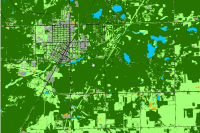

In [11]:
model_item = gis.content.get("a10f46a8071a4318bcc085dae26d7ee4") 
model_item

Check out the documentation for the model linked above.  It's a Deep Learning Package that is pretrained to classify the pixels in an imagery raster.  It will use the built-in logic that it contains to determine whether each pixel represents a structure, road surface, water, or open land (and more).

#### 2.  Download the model locally.

To use the model on this data that you've collected, you'll need to download it locally.  Luckily that's pretty easy using the ArcGIS API for Python.

In [12]:
model_local = model_item.download(
    save_path = r".", 
    file_name = model_item.name
) 
model_local

'.\\HighResolutionLandCoverClassification_USA.dlpk'

## Use the Model to Classify a Raster

You've gathered your input data and determined the transformation you want to make on the data via choosing a model.  Now it's time to apply that transformation and review the results.  For a start, use the most recent image.

#### 1.  Import arcpy.

To perform this analysis locally, you'll need the `arcpy` package.

In [1]:
import arcpy

#### 2.  Choose the path for an input raster.

In [16]:
import sys
sys.executable

'C:\\Users\\dav11274\\AppData\\Local\\ESRI\\conda\\envs\\deeplearning2\\python.exe'

Start with the 2022 raster then use the `arcpy.Exists()` function to confirm that you have a valid file path

In [2]:
input_raster = './mountain_house_2022.tif'

In [3]:
arcpy.Exists(input_raster)

True

#### 3.  Classify your raster.

Now you can use the **Classify Pixels Using Deep Learning** tool in the **Imagery Analysis** toolbox to classify the data.

In [11]:
fgdb = arcpy.management.CreateFileGDB('.','classified_rasters')[0]

In [12]:
arcpy.env.workspace = fgdb

In [17]:
arcpy.CheckOutExtension("ImageAnalyst")

'CheckedOut'

In [19]:
out_classified_raster = arcpy.ia.ClassifyPixelsUsingDeepLearning(
    in_raster = arcpy.Raster(input_raster),
    in_model_definition = model_local,
)
out_classified_raster

ExecuteError: A raster error has occurred. The messages that follow will provide more detail.
No raster store is configurated.
Failed to execute (ClassifyPixelsUsingDeepLearning).
